In [1]:
import random

import tqdm
import umap
import numpy as np
import pandas as pd
import sklearn
from sklearn import cluster        # Algoritmos de clustering.
from sklearn import datasets       # Crear datasets.
from sklearn import decomposition  # Algoritmos de reduccion de dimensionalidad.

# Visualizacion.
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

random_state = 42

%matplotlib inline

## 1. Métodos de *clustering*

Este ejercicio trata de explorar distintas técnicas de agrupamiento ajustándolas a distintos conjuntos de datos.

El objetivo es doble: entender la influencia de los parámetros en su comportamiento, y conocer sus limitaciones en la búsqueda de estructuras de datos.

### Generación de los conjuntos de datos

In [2]:
X_blobs, y_blobs = datasets.make_blobs(n_samples=1000, n_features=2, centers=4, cluster_std=1.6, random_state=random_state)
X_moons, y_moons = datasets.make_moons(n_samples=1000, noise=.07, random_state=random_state)
X_circles, y_circles = datasets.make_circles(n_samples=1000, factor=.5, noise=.05, random_state=random_state)

Cada dataset tiene 2 variables: una variable *X* que contiene 2 features (columnas) y tantas filas como muestras. Y una variable *y* que alberga las etiquetas que identifican cada cluster.

A lo largo del ejercicio no se usará la variable *y* (sólo con el objetivo de visualizar). El objetivo es a través de los distintos modelos de *clustering* conseguir encontrar las estructuras descritas por las variables *y*.

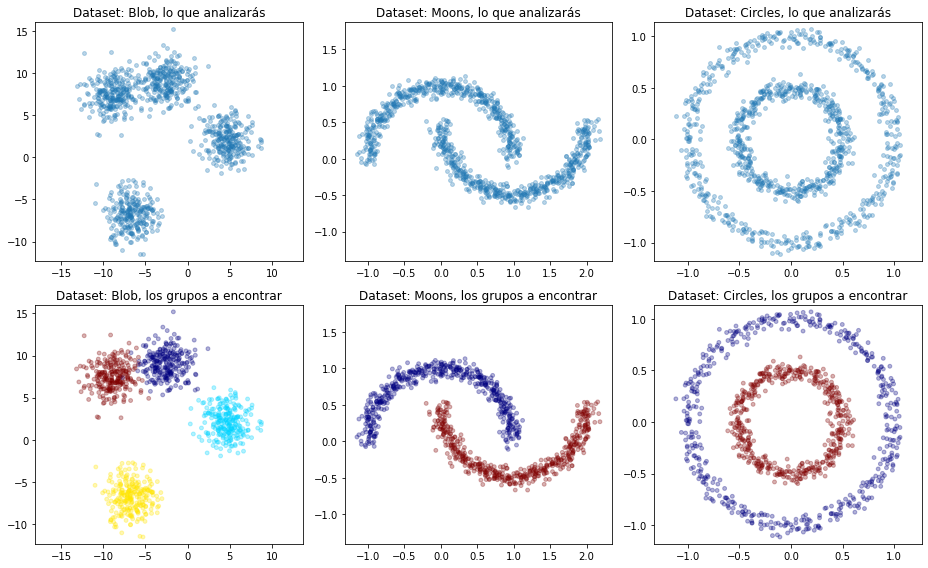

In [4]:
fig, axis = plt.subplots(2, 3, figsize=(13, 8))
for i, (X, y, ax, name) in enumerate(zip([X_blobs, X_moons, X_circles] * 2,
                                         [None] * 3 + [y_blobs, y_moons, y_circles],
                                         axis.reshape(-1),
                                         ['Blob', 'Moons', 'Circles'] * 2)):
    ax.set_title('Dataset: {}, '.format(name) + ('lo que analizarás' if i < 3 else 'los grupos a encontrar'))
    ax.scatter(X[:,0], X[:,1], s=15, c=y, alpha=.3, cmap='jet')
    ax.axis('equal')
plt.tight_layout()

### 1 c. Algoritmos jerárquicos

En este apartado se pide visualizar mediante un [dendrograma](https://en.wikipedia.org/wiki/Dendrogram) la construcción progresiva de los grupos mediante un algoritmo jerárquico aglomerativo (estrategia *bottom-up*). Con ello se pretende encontrar un método gráfico para entender el comportamiento del algoritmo y encontrar los *clusters* deseados en cada dataset.

In [5]:
X, y = X_blobs, y_blobs

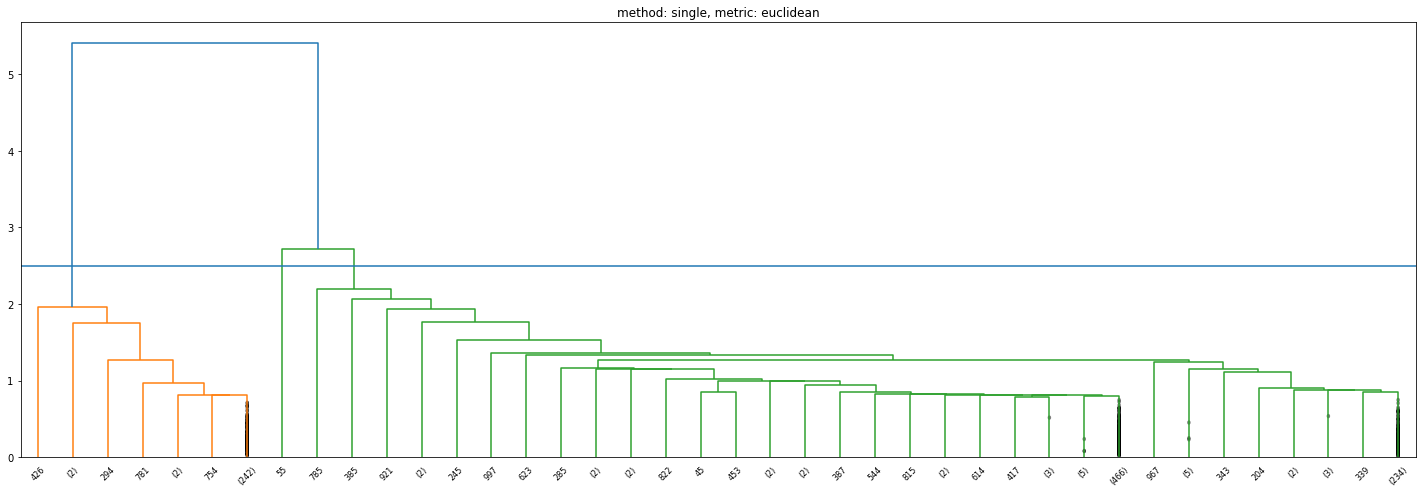

In [6]:
from scipy.cluster.hierarchy import dendrogram, linkage

plt.figure(figsize=(25,8))

z_single = linkage(X, method='single', metric='euclidean')
dendrogram(z_single, truncate_mode='lastp', p=40, show_contracted=True)
plt.title('method: single, metric: euclidean')
plt.axhline(2.5)
plt.show()

Se observa que con el enlace simple, es difícil obtener 4 clústers con la medida de distancia.

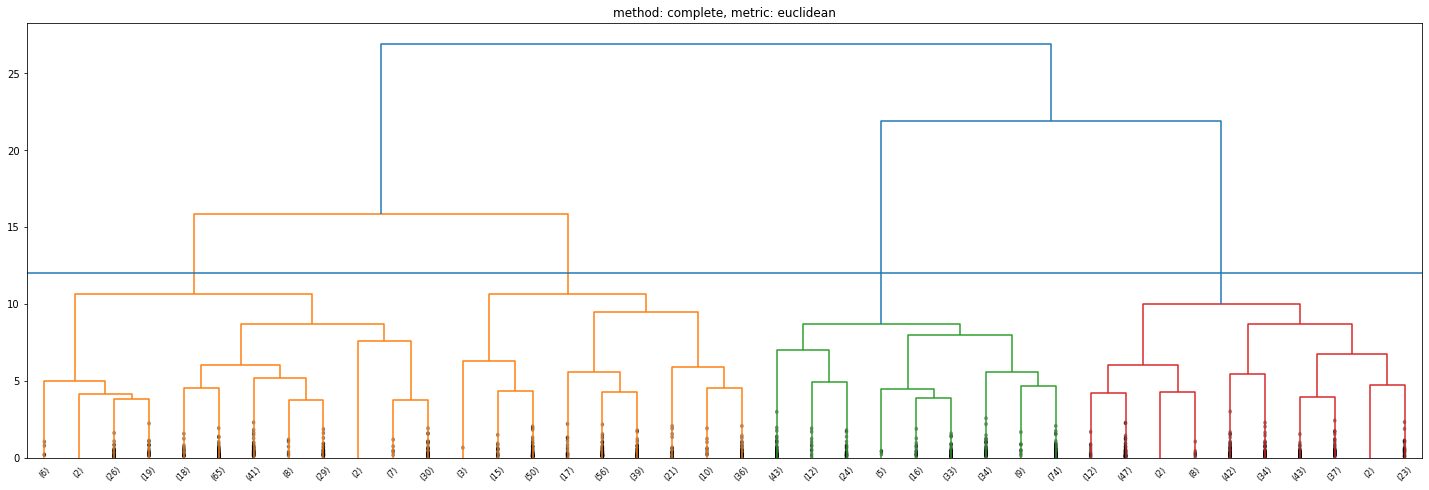

In [7]:
plt.figure(figsize=(25,8))

z_complete = linkage(X, method='complete', metric='euclidean')
dendrogram(z_complete, truncate_mode='lastp', p=40, show_contracted=True)
plt.title('method: complete, metric: euclidean')
plt.axhline(12)
plt.show()

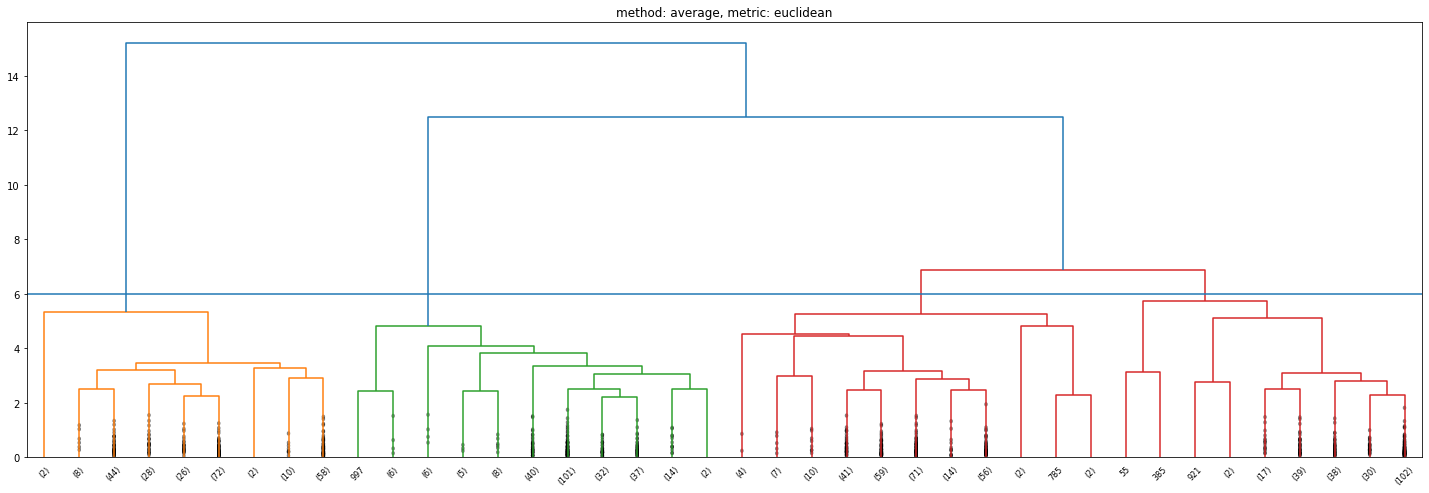

In [8]:
plt.figure(figsize=(25,8))

z_average = linkage(X, method='average', metric='euclidean')
dendrogram(z_average, truncate_mode='lastp', p=40, show_contracted=True)
plt.title('method: average, metric: euclidean')
plt.axhline(6)
plt.show()

El dataset **blobs** contiene 4 clústers. A través de los dendrogramas se observó que utilizando la distancia de 12 para el enlace completo y 6 para el enlace promedio se creaban 4 clústers. Por otro lado, con el enlace simple, no es fácil hallar 4 clústers con el criterio de la distancia.

A través de la clase `fcluster` se entrarán 4 clústers utilizando los criterios de distancia y número de cluster:

Text(0.5, 1.0, 'method: Average\n metric:euclidean\n k: 4')

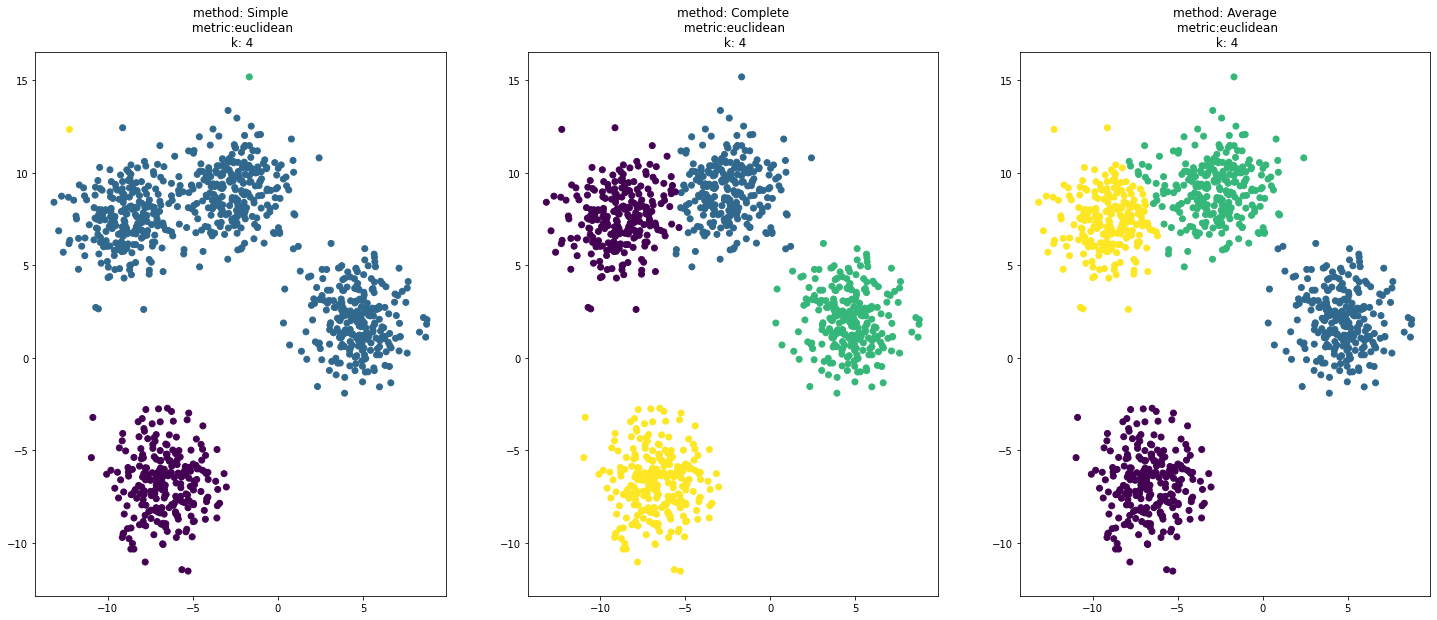

In [9]:
from scipy.cluster.hierarchy import fcluster

fig, axs = plt.subplots(1,3, figsize=(25,10))

clusters_s=fcluster(z_single, 4, criterion='maxclust')
axs[0].scatter(X[:,0],X[:,1], c=clusters_s)
axs[0].set_title('method: Simple\n metric:euclidean\n k: 4')

clusters_c=fcluster(z_complete, 12, criterion='distance')
axs[1].scatter(X[:,0],X[:,1], c=clusters_c)
axs[1].set_title('method: Complete\n metric:euclidean\n k: 4')

clusters_a=fcluster(z_average, 6, criterion='distance')
axs[2].scatter(X[:,0],X[:,1], c=clusters_a)
axs[2].set_title('method: Average\n metric:euclidean\n k: 4')

Por observación, se determinó una distancia de 12 y 6 en los dendrogramas utilizando los enlaces completo y promedio para encontrar 4 clústers. Para el caso del enlace simple, se utilizó el criterio de numero de clústers.


Los enlaces que se comportaron mejor fueron el completo y el promedio. A diferencia del enlace simple que se vio afectado por los valores extremos del dataset y la distancia que existe entre los diferentes conjuntos.

Con el enlace simple, para formar 4 clústers se crearon 2 agrupaciones con un registro cada uno, como se muestra a continuación:

In [12]:
def sum_cluster(cluster, n):
    result = 0
    for val in cluster:
        if val == n:
            result += 1
    return result

print('Enlace Simple\ncluster 3: {} elemento, cluster 4: {} elemento'
      .format(sum_cluster(clusters_s, 3), sum_cluster(clusters_s, 3)))

Enlace Simple
cluster 3: 1 elemento, cluster 4: 1 elemento


Inpeccionamos unos de los elementos formados por un clústers:

In [13]:
np.where(X == X[X[:, 1] > 15])

(array([785, 785], dtype=int64), array([0, 1], dtype=int64))

In [14]:
z_single[785 - len(X)]

array([8.61000000e+02, 1.68900000e+03, 3.78892475e-01, 3.00000000e+00])

El registro esta formado por 3 clústers a una distancia de 4.

In [15]:
X, y = X_moons, y_moons

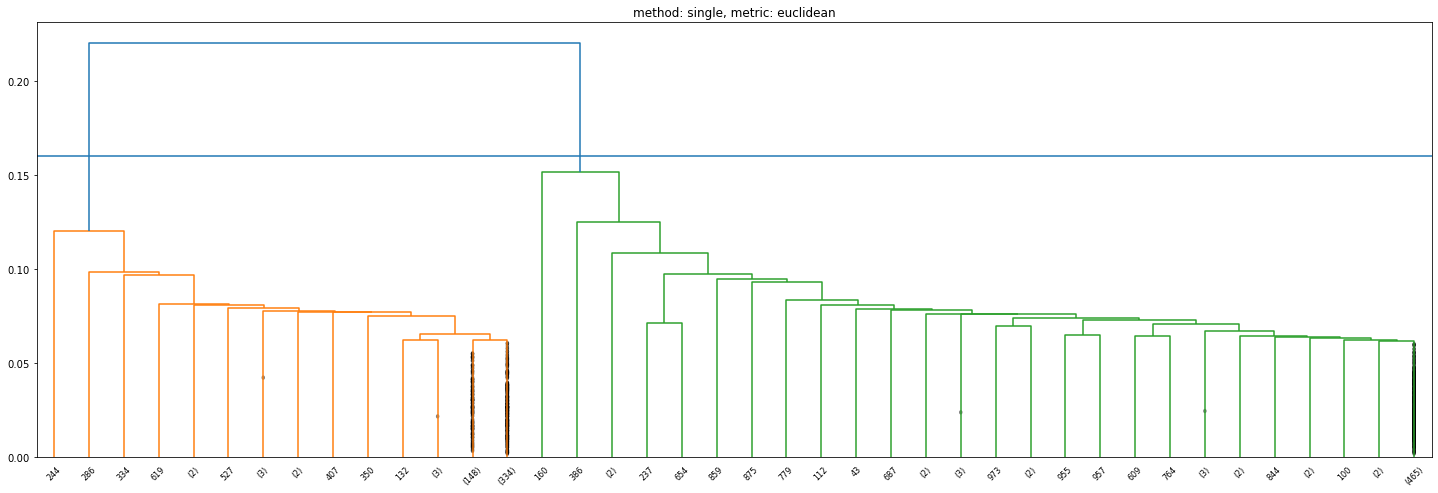

In [16]:
plt.figure(figsize=(25,8))

z_single = linkage(X, method='single', metric='euclidean')
dendrogram(z_single, truncate_mode='lastp', p=40, show_contracted=True)
plt.title('method: single, metric: euclidean')
plt.axhline(0.16)
plt.show()

Se observa que, con el enlace completo, para obtener 4 clústers la distancia es de 2.4 de aproximadamente.

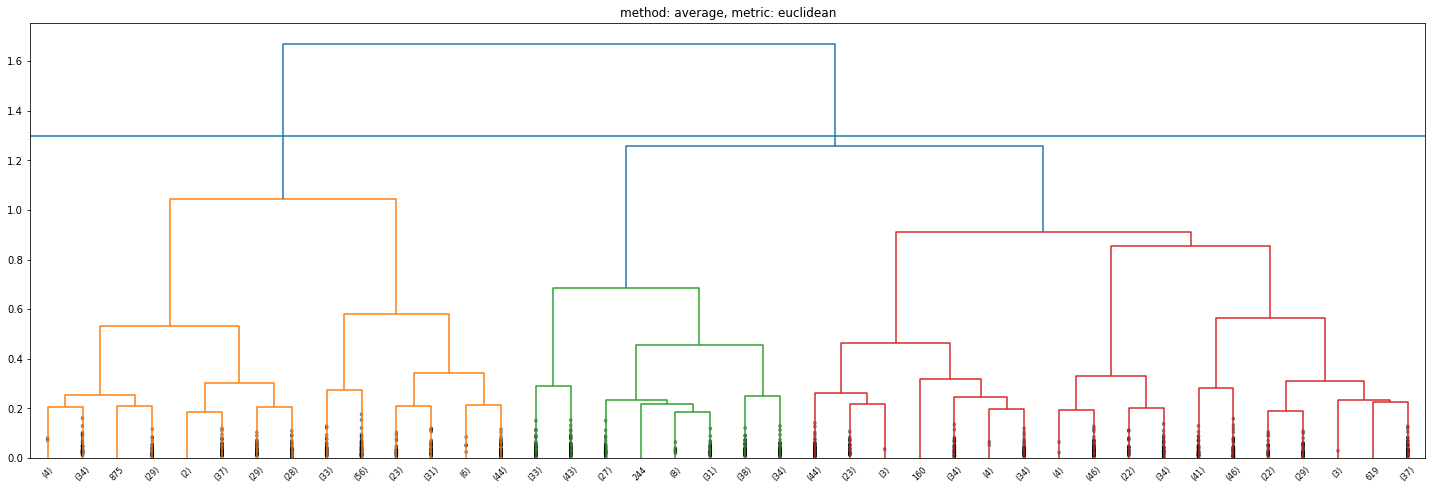

In [17]:
plt.figure(figsize=(25,8))

z_average = linkage(X, method='average', metric='euclidean')
dendrogram(z_average, truncate_mode='lastp', p=40, show_contracted=True)
plt.title('method: average, metric: euclidean')
plt.axhline(1.3)
plt.show()

Se observa que, con el enlace completo, para obtener 4 clústers la distancia es de 1.3 de aproximadamente

Text(0.5, 1.0, 'method: Average\n metric:euclidean\n k: 2')

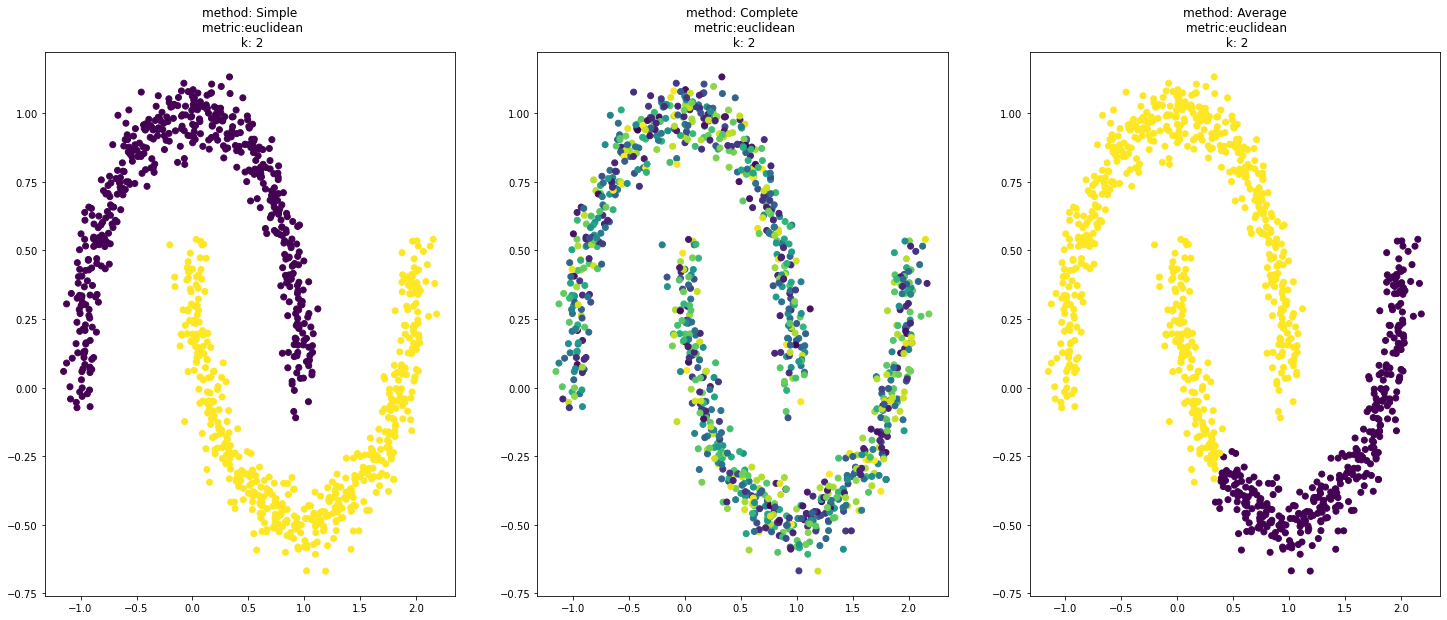

In [18]:
from scipy.cluster.hierarchy import fcluster

fig, axs = plt.subplots(1,3, figsize=(25,10))

clusters=fcluster(z_single, 0.16, criterion='distance')
axs[0].scatter(X[:,0],X[:,1], c=clusters)
axs[0].set_title('method: Simple\n metric:euclidean\n k: 2')

clusters=fcluster(z_complete, 2.4, criterion='distance')
axs[1].scatter(X[:,0],X[:,1], c=clusters)
axs[1].set_title('method: Complete\n metric:euclidean\n k: 2')

clusters=fcluster(z_average, 1.3, criterion='distance')
axs[2].scatter(X[:,0],X[:,1], c=clusters)
axs[2].set_title('method: Average\n metric:euclidean\n k: 2')

El dataset **moons** contiene 2 zonas con alta densidad de concentración de puntos. 

Por observación, se determinó que los dendrogramas que utilizaron los enlaces simple, completo y promedio formaron 2 clústers con las distancias 0.16, 2.4 y 1.3 respectivamente.

La distancia que existe entre las dos agrupaciones favoreció al enlace simple debido a que este conecta dos clústers seleccionado la distancia menor entre los elementos de dichos clústers.

In [19]:
X, y = X_circles, y_circles

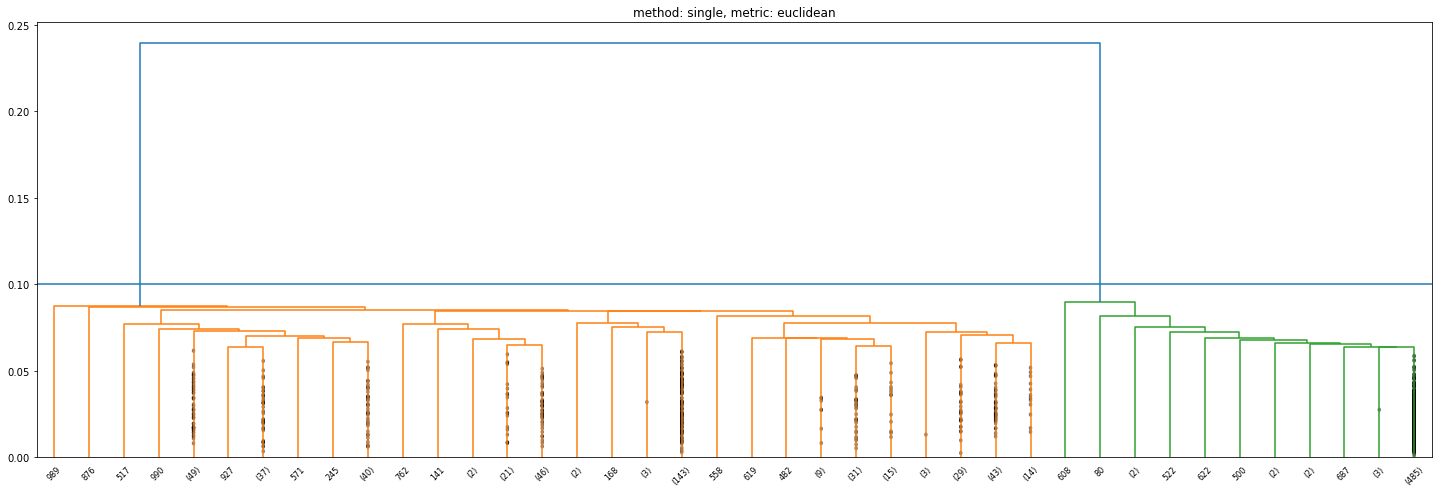

In [20]:
plt.figure(figsize=(25,8))

z_single = linkage(X, method='single', metric='euclidean')
dendrogram(z_single, truncate_mode='lastp', p=40, show_contracted=True)
plt.title('method: single, metric: euclidean')
plt.axhline(0.10)
plt.show()

Se observa que, con el enlace simple, para obtener 4 clústers la distancia es de 0.10 aproximadamente.

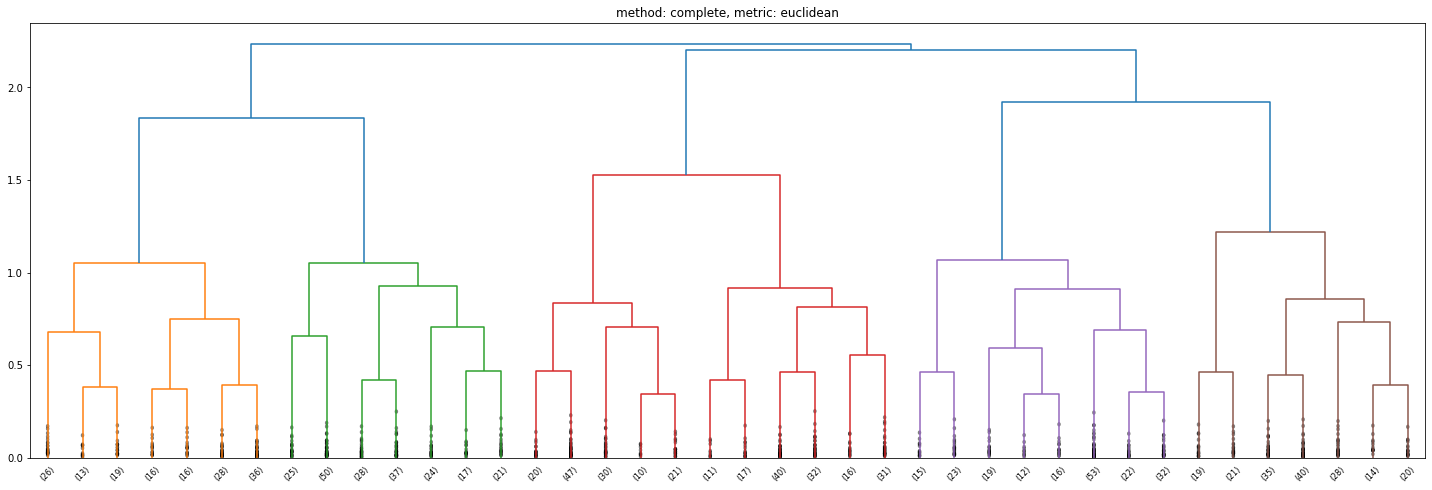

In [21]:
plt.figure(figsize=(25,8))

z_complete = linkage(X, method='complete', metric='euclidean')
dendrogram(z_complete, truncate_mode='lastp', p=40, show_contracted=True)
plt.title('method: complete, metric: euclidean')
plt.show()

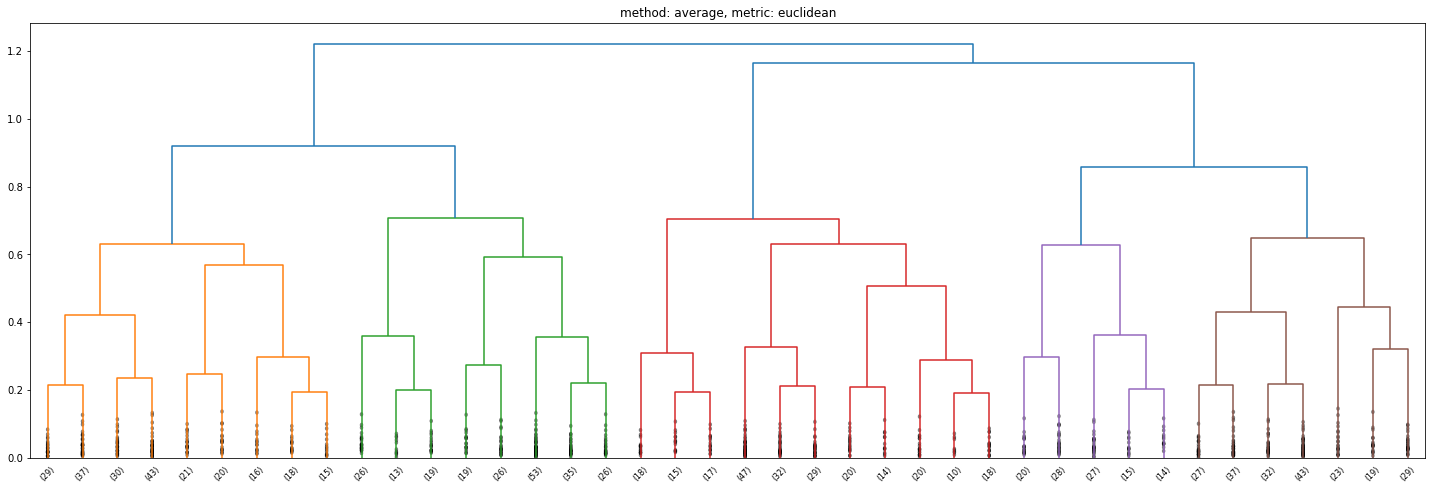

In [22]:
plt.figure(figsize=(25,8))

z_average = linkage(X, method='average', metric='euclidean')
dendrogram(z_average, truncate_mode='lastp', p=40, show_contracted=True)
plt.title('method: average, metric: euclidean')
plt.show()

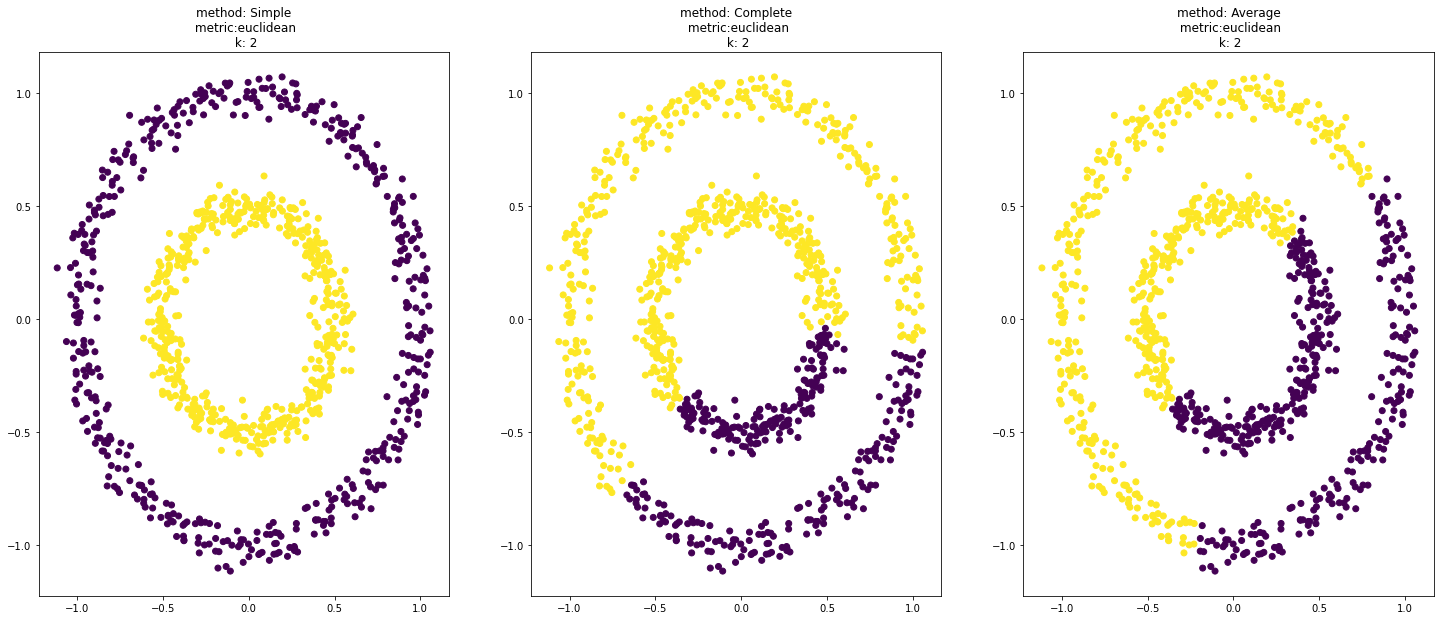

In [23]:
from scipy.cluster.hierarchy import fcluster

fig, axs = plt.subplots(1,3, figsize=(25,10))

clusters=fcluster(z_single, 0.10, criterion='distance')
axs[0].scatter(X[:,0],X[:,1], c=clusters)
axs[0].set_title('method: Simple\n metric:euclidean\n k: 2')

clusters=fcluster(z_complete, 2, criterion='maxclust')
axs[1].scatter(X[:,0],X[:,1], c=clusters)
axs[1].set_title('method: Complete\n metric:euclidean\n k: 2')

clusters=fcluster(z_average, 2, criterion='maxclust')
axs[2].scatter(X[:,0],X[:,1], c=clusters)
axs[2].set_title('method: Average\n metric:euclidean\n k: 2')
plt.show()